In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
find_latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
find_latest_date

('2017-08-23',)

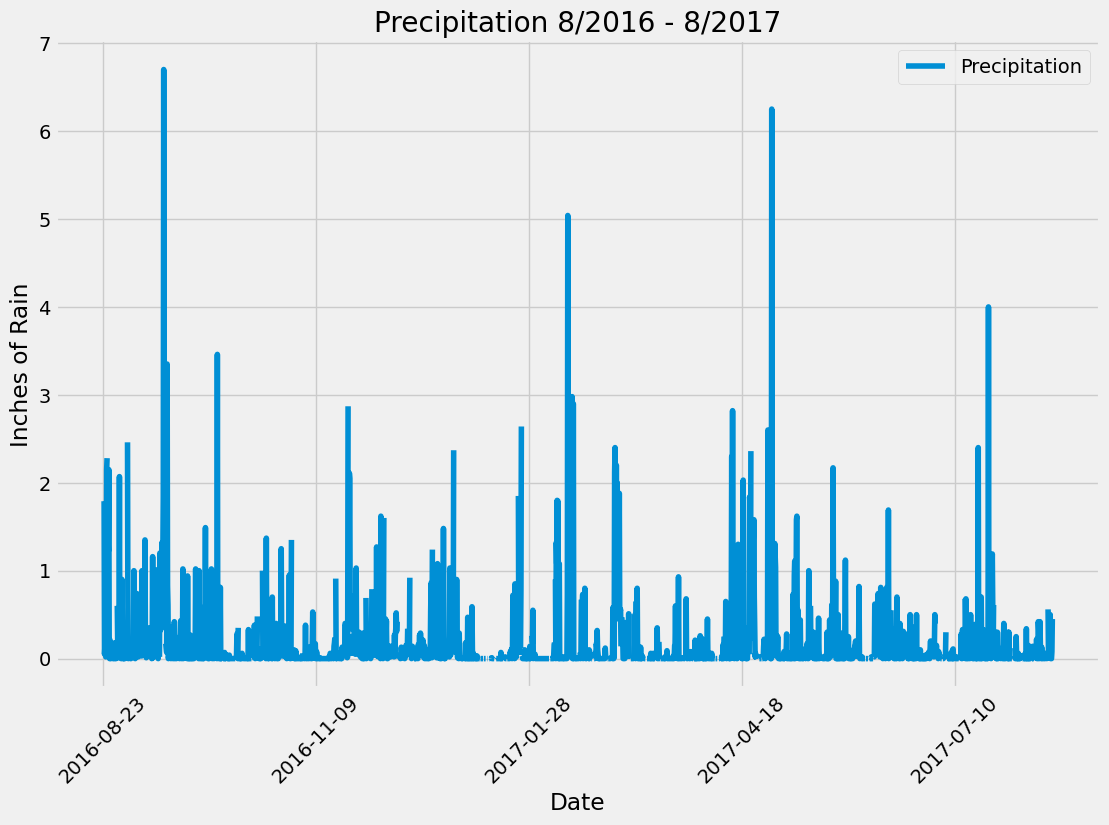

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
year_ago = latest_date - dt.timedelta(days = 365)
year_ago

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime('%Y-%m-%d', Measurement.date) >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measure_df = pd.DataFrame(query).rename(columns = {'date': 'Date', 'prcp': 'Precipitation'})
measure_df.set_index('Date', inplace=True)

# Sort the dataframe by date
measure_df = measure_df.sort_index()
measure_df

# Use Pandas Plotting with Matplotlib to plot the data
measure_df.plot(title = 'Precipitation 8/2016 - 8/2017',figsize = (12, 8), rot = 45)
plt.legend(loc = 'upper right')
plt.ylabel('Inches of Rain')
plt.xlabel('Date')
#plt.title('Precipitation 8/2016 - 8/2017')
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
measure_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station_list = [Measurement.station, func.count(Measurement.station)]

active_station = session.query(*active_station_list).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first().station

session.query(*active_station_list).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_list = [Measurement.station,
                   func.min(Measurement.tobs),
                   func.max(Measurement.tobs),
                   func.round(func.avg(Measurement.tobs),2)]

most_active_station = session.query(*temperature_list).filter_by(station = 'USC00519281').all()

#temperature_list
#most_active_station

print(f"The most active station id is {most_active_station[0][0]}.")
print(f"The lowest temperature for station {most_active_station[0][0]} is {most_active_station[0][1]}.")
print(f"The highest temperature for station {most_active_station[0][0]} is {most_active_station[0][2]}.")
print(f"The average temperature for station {most_active_station[0][0]} is {most_active_station[0][3]}.")

The most active station id is USC00519281.
The lowest temperature for station USC00519281 is 54.0.
The highest temperature for station USC00519281 is 85.0.
The average temperature for station USC00519281 is 71.66.


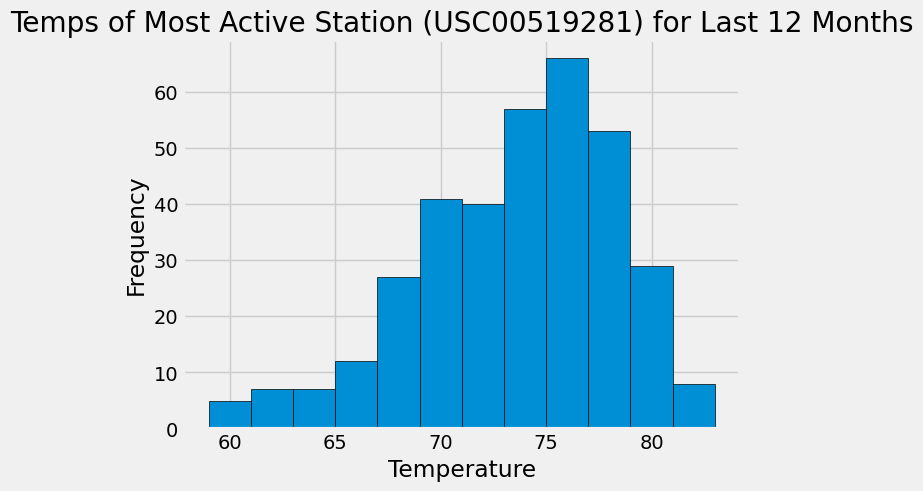

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_months = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= year_ago).all()

# Create data frame
last_12_months_df = pd.DataFrame(last_12_months)

# Create histogram
plt.hist(last_12_months_df['tobs'], bins = 12, edgecolor = 'black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temps of Most Active Station ({most_active_station[0][0]}) for Last 12 Months')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()